In [12]:
import os
import numpy as np 
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm
from shapely.geometry import Point,Polygon
import seaborn as sns
%matplotlib inline


sh_od = pd.read_csv('./data-sample/sh_od.csv')
print (sh_od.head())
sh_od = sh_od[['vehicle_num','date','longitude','latitude','status']]
sh_od.info()

   Unnamed: 0  vehicle_num                 date   longitude  latitude  status
0        2114        10004  2007-02-20 00:08:45  121.414583     31.16       1
1        2115        10004  2007-02-20 00:11:55  121.414583     31.16       1
2        2116        10004  2007-02-20 00:18:13  121.414583     31.16       1
3        2117        10004  2007-02-20 00:24:31  121.414583     31.16       1
4        2118        10004  2007-02-20 00:27:40  121.414583     31.16       1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4429131 entries, 0 to 4429130
Data columns (total 5 columns):
vehicle_num    int64
date           object
longitude      float64
latitude       float64
status         int64
dtypes: float64(2), int64(2), object(1)
memory usage: 169.0+ MB


坐标系栅格化

In [2]:
import math

lon_min = min(sh_od.longitude)
lon_max = max(sh_od.longitude)
lat_min = min(sh_od.latitude)
lat_max = max(sh_od.latitude)

# 区块大小设置200m
box_size = 200
#Calculate the length of latitude and longitude of the grids: ▲Lon and ▲Lat
deltaLon = box_size * 360 / (2 * math.pi * 6371004 * math.cos((lat_min + lat_max) * math.pi / 360))
deltaLat = box_size * 360 / (2 * math.pi * 6371004)

lon_box_count = int((lon_max-lon_min)/deltaLon)
lat_box_count = int((lat_max-lat_min)/deltaLat)

print (f'经度的delta大小为{deltaLon}')
print (f'维度的delta大小为{deltaLat}')
print (f'上海区域的经度区块为{lon_box_count}个，区块为正方形，区块长度设置为{box_size}')
print (f'上海区域的经度区块为{lat_box_count}个，区块为正方形，区块长度设置为{box_size}')

经度的delta大小为0.002098381230158049
维度的delta大小为0.0017986420825691627
上海区域的经度区块为952个，区块为正方形，区块长度设置为200
上海区域的经度区块为1109个，区块为正方形，区块长度设置为200


In [3]:
geometry = []
lon_box_num = []
lat_box_num = []
lon_box_cen = []
lat_box_cen = []

# count = 0
for box_x in range(lon_box_count):
    for box_y in range(lat_box_count):
        # count = count + 1
        # if count > 10000:
        #     break
        lon_1 = box_x*deltaLon + lon_min
        lat_1 = box_y*deltaLat + lat_min
        lon_2 = (box_x+1)*deltaLon + lon_min
        lat_2 = (box_y+1)*deltaLat + lat_min
        poly = Polygon([(lon_1,lat_1),(lon_1,lat_2),(lon_2,lat_2),(lon_2,lat_1)])
        
        lon_box_num.append(box_x)
        lat_box_num.append(box_y)
        lon_box_cen.append((lon_1+lon_2)/2)
        lat_box_cen.append((lat_1+lat_2)/2)
        geometry.append(poly)

sh_grid = gpd.GeoDataFrame()
sh_grid['lon_box_num'] = lon_box_num
sh_grid['lat_box_num'] = lat_box_num
sh_grid['lon_box_cen'] = lon_box_cen
sh_grid['lat_box_cen'] = lat_box_cen
sh_grid['geometry'] = geometry

In [5]:
# 将sh_od数据与上海的行政区块进行空间连接
# 将超出区域除去
# 即使只有17万条数据，使用sh_grid来画图还是要1分钟10秒
sh_xzgh = gpd.GeoDataFrame.from_file('./shapefile/shanghai_shp/区县界_area.shp')

print (sh_grid.shape)
bool_connect = sh_grid.intersects(sh_xzgh.unary_union)
print (f'{np.sum(bool_connect)}，{np.sum(-bool_connect)}分别表示行政区块内数据数，外数据数')
sh_grid = sh_grid[bool_connect]
print (sh_grid.shape) 
sh_grid.to_file('./shapefile/shanghai_shp/sh_grid.shp',encoding='utf-8')

(174218, 5)
174218，0分别表示行政区块内数据数，外数据数
(174218, 5)


F:\anaconda\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  # This is added back by InteractiveShellApp.init_path()


处理出租车数据，获取出租车的出发地与目的地

统计出发点与目的点在地图上的数量分布

In [6]:
sh_od = sh_od.sort_values(['vehicle_num','date']).reset_index()
print (sh_od.head())
sh_od['vehicle_num1'] = sh_od['vehicle_num'].shift(-1)
sh_od['status1'] = sh_od['status'].shift(-1) #上移，但是也要记录目标点的经纬度以及时间
sh_od['change_status'] = sh_od['status1'] - sh_od['status'] #1代表上车，-1代表下车，0表示状态不变

sh_od = sh_od[((sh_od['change_status']==1)|(sh_od['change_status']==-1))&(sh_od['vehicle_num']==sh_od['vehicle_num1'])]

    index  vehicle_num                 date  longitude  latitude  status
0  116078          105  2007-02-20 00:01:17   121.4681   31.2211       0
1  116079          105  2007-02-20 00:01:33   121.4695   31.2216       0
2  116080          105  2007-02-20 00:01:49   121.4700   31.2216       0
3  116081          105  2007-02-20 00:02:50   121.4695   31.2215       0
4  116082          105  2007-02-20 00:03:51   121.4695   31.2218       0


In [7]:
sh_od['longitude1'] = sh_od['longitude'].shift(-1)
sh_od['latitude1'] = sh_od['latitude'].shift(-1)
sh_od['date1'] = sh_od['date'].shift(-1)
# 获取上车下车节点数据,由于上车下车会重复，故只取上车数据当change——status为1
sh_od = sh_od[sh_od['change_status']==1]
sh_od.head()

,index,vehicle_num,date,longitude,latitude,status,vehicle_num1,status1,change_status,longitude1,latitude1,date1
119,116197,105,2007-02-20 01:38:47,121.4753,31.2271,0,105.0,1.0,1.0,121.4700,31.2068,2007-02-20 01:46:12
156,116234,105,2007-02-20 02:03:13,121.4696,31.2205,0,105.0,1.0,1.0,121.5388,31.2446,2007-02-20 02:17:51
173,116251,105,2007-02-20 02:20:49,121.5390,31.2443,0,105.0,1.0,1.0,121.5416,31.2343,2007-02-20 02:24:28
213,116291,105,2007-02-20 02:41:27,121.5050,31.2373,0,105.0,1.0,1.0,121.4770,31.2140,2007-02-20 02:51:03
235,116313,105,2007-02-20 02:56:11,121.4700,31.2203,0,105.0,1.0,1.0,121.5186,31.1466,2007-02-20 03:15:23


In [8]:
sh_od_point = sh_od[['vehicle_num','longitude','latitude','date','longitude1','latitude1','date1']].copy()
time_stamp_func = lambda x: int((x.split(' ')[1]).split(':')[0])*3600+\
                            int((x.split(' ')[1]).split(':')[1])*60+\
                            int((x.split(' ')[1]).split(':')[2])
sh_od_point['time_stamp'] = sh_od_point['date'].apply(time_stamp_func)
sh_od_point['time_stamp1'] = sh_od_point['date1'].apply(time_stamp_func)
# 换算成分钟
sh_od_point['duration'] = round((sh_od_point['time_stamp1'] - sh_od_point['time_stamp'])/60,2)
sh_od_point = sh_od_point.drop(['date','date1','time_stamp','time_stamp1'],axis=1)
sh_od_point.to_csv('./data-sample/sh_od_point.csv',encoding='utf-8')
sh_od_point

,vehicle_num,longitude,latitude,longitude1,latitude1,duration
119,105,121.4753,31.2271,121.4700,31.2068,7.42
156,105,121.4696,31.2205,121.5388,31.2446,14.63
173,105,121.5390,31.2443,121.5416,31.2343,3.65
213,105,121.5050,31.2373,121.4770,31.2140,9.60
235,105,121.4700,31.2203,121.5186,31.1466,19.20
...,...,...,...,...,...,...
4428873,99780,121.4250,31.2020,121.4810,31.2641,23.17
4428902,99780,121.4793,31.2646,121.4813,31.2813,10.25
4428927,99780,121.4761,31.2708,121.5350,31.2926,20.47
4428964,99780,121.5205,31.2835,121.5743,31.2778,17.45


1. 出租车数据已经处理好了

2. 栅格化系统也设置好了

任务：1与2结合，统计出租车起点终点的栅格分布空间图

In [9]:
sh_od_point = pd.read_csv('./data-sample/sh_od_point.csv')
# 计算gps数据中起点与终点的划分栅格号，并保存相应栅格的中心位置
sh_od_point['lon_box_num'] = ((sh_od_point['longitude'] - (lon_min))/deltaLon).astype('int')
sh_od_point['lat_box_num'] = ((sh_od_point['latitude'] - (lat_min))/deltaLat).astype('int')
sh_od_point['lon_box_num1'] = ((sh_od_point['longitude1'] - (lon_min))/deltaLon).astype('int')
sh_od_point['lat_box_num1'] = ((sh_od_point['latitude1'] - (lat_min))/deltaLat).astype('int')
agg_dict = {'vehicle_num':(lambda x: len(x)),
            'longitude':(lambda x: np.mean(x)),
            'latitude':(lambda x: np.mean(x)),
            'longitude1':(lambda x: np.mean(x)),
            'latitude1':(lambda x: np.mean(x))}
sh_od_point = sh_od_point.groupby(['lon_box_num','lat_box_num','lon_box_num1','lat_box_num1']).agg(agg_dict).reset_index()

sh_od_point = sh_od_point.sort_values(['vehicle_num'],ascending=False)

sh_od_point.head()
# 由于gps定位可能出错，导致显示司机位置偏移过大，故先进行过滤
#Filter out the grids that are not in the research scope
# TaxiOD = TaxiOD[(TaxiOD['SLONCOL']>=0) & (TaxiOD['SLATCOL']>=0) &(TaxiOD['ELONCOL']>=0) & (TaxiOD['ELATCOL']>=0)&
# (TaxiOD['SLONCOL']<=lonsnum) & (TaxiOD['SLATCOL']<=latsnum) &(TaxiOD['ELONCOL']<=lonsnum) & (TaxiOD['ELATCOL']<=latsnum)]

,lon_box_num,lat_box_num,lon_box_num1,lat_box_num1,vehicle_num,longitude,latitude,longitude1,latitude1
47750,701,740,682,731,309,121.472986,31.335596,121.432490,31.319103
842,571,577,709,666,269,121.199601,31.042550,121.489494,31.201499
1812,603,617,702,734,245,121.267200,31.113345,121.475994,31.323762
43250,697,706,687,704,180,121.464935,31.273632,121.444454,31.270312
23310,676,722,316,281,177,121.420701,31.302731,120.664549,30.508699


画图

In [10]:
from shapely.geometry import LineString
sh_od_point = sh_od_point[sh_od_point['vehicle_num']>=5]
sh_od_point['geometry'] = sh_od_point.apply(lambda x: LineString([[x['longitude'],x['latitude']],[x['longitude1'],x['latitude1']]]),axis=1)
sh_od_point = gpd.GeoDataFrame(sh_od_point)
sh_od_point['line_width'] = np.log(sh_od_point['vehicle_num'])

36.90201282501221 s to plot the grids and shanghai shape
 1.061185359954834 s to plot OD


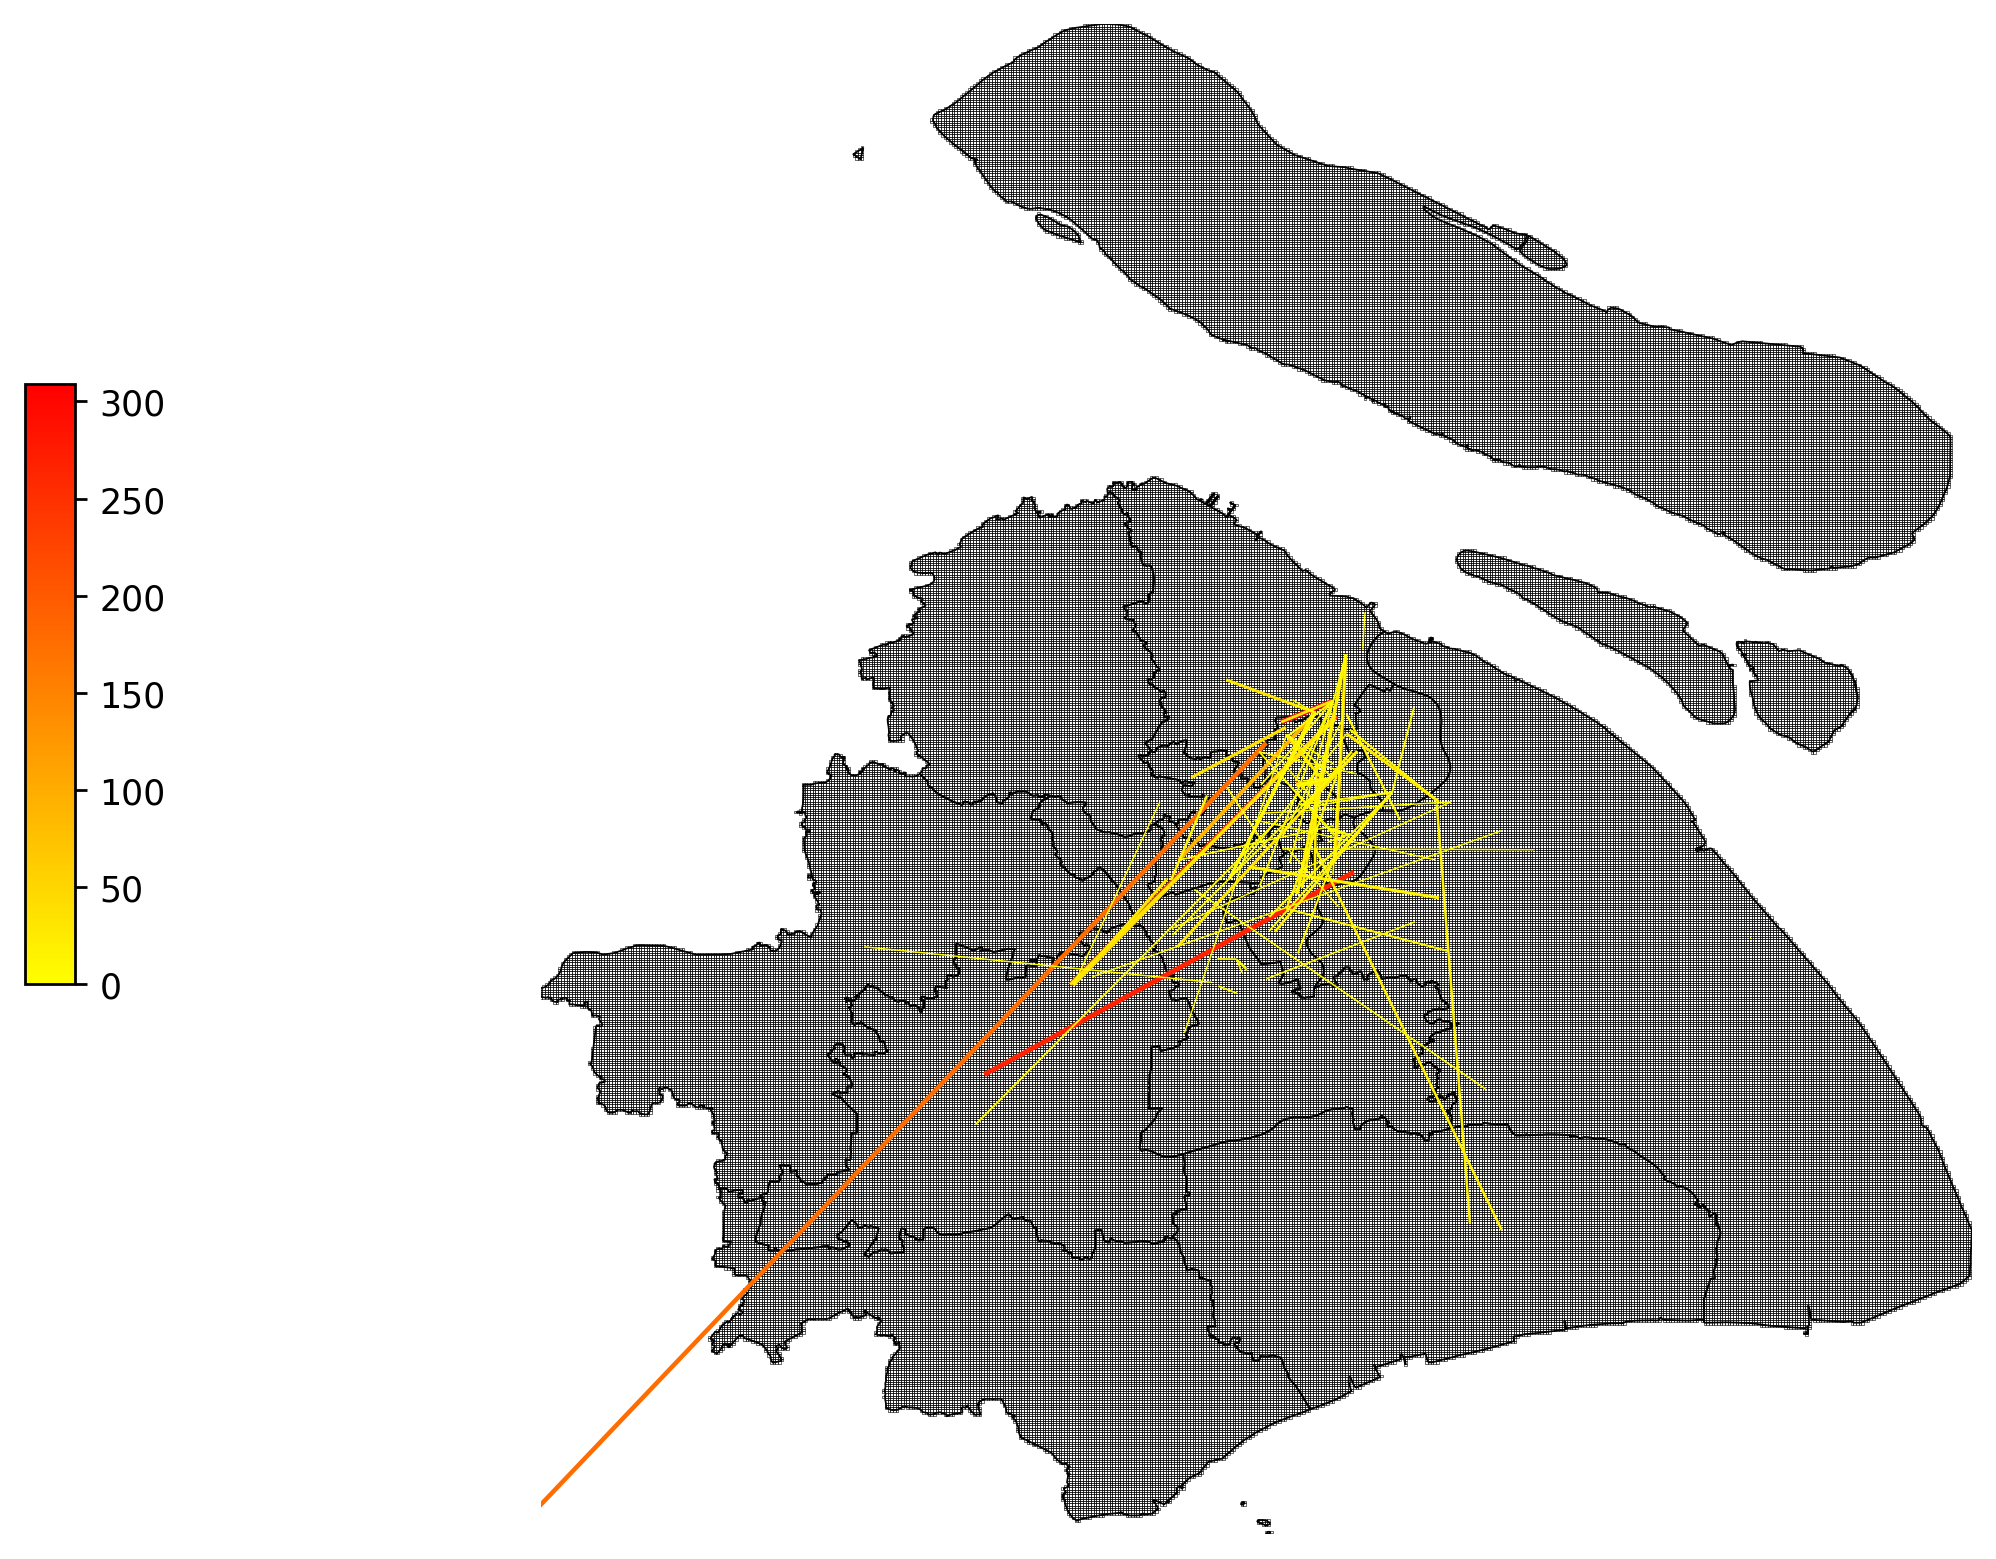

In [11]:
# 大多数还是1，因此选取相同数量大于5，才来画图

fig     = plt.figure(1,(10,8),dpi = 250)    
ax      = plt.subplot(111)
plt.sca(ax)

#time it
import time
timeflag = time.time()

sh_grid.plot(ax = ax,edgecolor = (0,0,0,0.8),facecolor = (0,0,0,0),linewidths=0.2)
sh_xzgh.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0),linewidths=0.5)
print(time.time()-timeflag,'s to plot the grids and shanghai shape')

import matplotlib
timeflag = time.time()

vmax =sh_od_point['vehicle_num'].max()
cmapname = 'autumn_r'
cmap = matplotlib.cm.get_cmap(cmapname)
#plot OD
# 通过色彩深度以及线条粗度，体现地区聚集度
sh_od_point.plot(ax = ax,column = 'vehicle_num',vmax = vmax,vmin = 0,cmap = cmap,linewidth = sh_od_point['line_width']/4)
print('',time.time()-timeflag,'s to plot OD')

plt.axis('off')    
plt.imshow([[0,vmax]], cmap=cmap)
cax = plt.axes([0.02, 0.4, 0.02, 0.3])
plt.colorbar(cax=cax)
ax.set_xlim(120.8517,121.9741)
ax.set_ylim(30.6823,31.8666)
plt.savefig('images/taxi_start2end.png',dpi=250)
plt.show()